In [334]:
# Install required packages
%pip install numpy pandas matplotlib scipy plotly

Note: you may need to restart the kernel to use updated packages.


# Accelerometer Data Analysis
##### By Mateo Robayo B. - Universidad Nacional de Colombia, Sede Medellín - Laboratorio de Instrumentación Electrónica (Bloque 58)

This notebook analyzes 3-axis accelerometer data from the IIS3DWB sensor.

## Data Overview
- **Sensor**: IIS3DWB 3-axis accelerometer by STM32
- **Configuration**: FIFO continuous mode WTM = 20, Sensitivity = ±4g
- **Resolution**: Timestamp = 12.5μs/LSB, Acceleration = 0.122mg/LSB
- **Data Format**: Timestamp(μs), accelX(mg), accelY(mg), accelZ(mg)

In [335]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import os

# Plotly imports for interactive plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Configure Plotly for Jupyter notebook
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Set plotting style for matplotlib (backup)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# SET FILE NAME HERE!!!
data_file = 'example_data.txt'  # Uncomment this for see the example data
# data_file = 'record_1.txt'  # Uncomment this for recorded data (save the file in the same folder than the .ipynb script)

# ============================================================================
# USER-CONTROLLABLE PLOTTING PARAMETERS
# ============================================================================
# Set your desired parameters below before running analysis functions

# Maximum frequency for spectral analysis plots (Hz)
# Options: 
#   - None: Auto-detect optimal range based on data
#   - Specific value: e.g., 50, 100, 1000, 3000, 6300
USER_MAX_FREQ = 1600  # Change this to your desired max frequency

# Additional plotting options
COLOR_MAP = 'inferno'          # Colormap for spectrograms ('viridis', 'plasma', 'inferno')

# Plotly configuration
PLOT_OPTIONS = {
    'width': 1200,
    'height': 800,
    'template': 'plotly_white',
    'line_width': 1.5,
    'font_size': 12
}

# Plot appearance settings
LINE_ALPHA = 0.8
FIGURE_DPI = 100

print("Libraries imported successfully!")
print(f"Current settings:")
print(f"  Max frequency: {'Auto-detect' if USER_MAX_FREQ is None else f'{USER_MAX_FREQ} Hz'}")
print(f"  Spectrogram colormap: {COLOR_MAP}")
print(f"  Interactive plots: Enabled (Plotly)")
print(f"\nTo change settings, modify the parameters above and re-run this cell.")

Libraries imported successfully!
Current settings:
  Max frequency: 1600 Hz
  Spectrogram colormap: inferno
  Interactive plots: Enabled (Plotly)

To change settings, modify the parameters above and re-run this cell.


## 1. Data Loading and Preprocessing

First, we'll load the data from `record_1.txt`, remove the header lines, and parse the accelerometer readings.

In [336]:
# Load and preprocess the data
def load_accelerometer_data(filename):
    """
    Load accelerometer data from text file, removing header lines.
    
    Parameters:
    filename (str): Path to the data file 
    
    Returns:
    pandas.DataFrame: DataFrame with columns ['timestamp', 'accel_x', 'accel_y', 'accel_z']
    """
    
    # Read the file and skip the first 6 header lines
    with open(filename, 'r') as file:
        lines = file.readlines()[6:]  # Skip header lines
    
    # Parse the data
    data = []
    for line in lines:
        line = line.strip()
        if line:  # Skip empty lines
            parts = line.split()
            if len(parts) == 4:  # Ensure we have all 4 values
                timestamp = float(parts[0])
                accel_x = float(parts[1])
                accel_y = float(parts[2])
                accel_z = float(parts[3])
                data.append([timestamp, accel_x, accel_y, accel_z])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'accel_x', 'accel_y', 'accel_z'])
    
    # Convert timestamp from microseconds to seconds for easier analysis
    df['time_seconds'] = df['timestamp'] / 1e6
    
    return df

# Load the data
if os.path.exists(data_file):
    df = load_accelerometer_data(data_file)
    print(f"Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Time range: {df['time_seconds'].min():.3f}s to {df['time_seconds'].max():.3f}s")
    print(f"Duration: {df['time_seconds'].max() - df['time_seconds'].min():.3f}s")
    print("\nFirst few rows:")
    print(df.head())
else:
    print(f"Error: File '{data_file}' not found!")

Data loaded successfully!
Dataset shape: (2452, 5)
Time range: 0.008s to 0.387s
Duration: 0.379s

First few rows:
   timestamp  accel_x  accel_y  accel_z  time_seconds
0     8039.0    361.0   -799.0   8145.0      0.008039
1     8042.0    538.0   -802.0   7887.0      0.008042
2     8045.0    666.0   -754.0   7891.0      0.008045
3     8048.0    342.0   -821.0   7842.0      0.008048
4     8051.0    440.0   -643.0   7769.0      0.008051


## 2. Time Series Analysis

Let's visualize the accelerometer data for each axis over time to understand the motion patterns.

In [337]:
# Plot time series data for each axis - Interactive Version
def plot_time_series(df):
    """
    Create interactive time series plots for accelerometer data using Plotly
    """
    # Create subplots
    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=('X-Axis Acceleration over Time', 
                       'Y-Axis Acceleration over Time', 
                       'Z-Axis Acceleration over Time'),
        vertical_spacing=0.08
    )
    
    # Color scheme
    colors = ['red', 'green', 'blue']
    axes_data = ['accel_x', 'accel_y', 'accel_z']
    axes_labels = ['X-Acceleration (mg)', 'Y-Acceleration (mg)', 'Z-Acceleration (mg)']
    
    # Add traces for each axis
    for i, (axis, color, label) in enumerate(zip(axes_data, colors, axes_labels)):
        fig.add_trace(
            go.Scatter(
                x=df['time_seconds'],
                y=df[axis],
                mode='lines',
                line=dict(color=color, width=PLOT_OPTIONS['line_width']),
                name=f'{axis.upper()}',
                opacity=LINE_ALPHA,
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Time: %{x:.4f} s<br>' +
                             'Acceleration: %{y:.2f} mg<br>' +
                             '<extra></extra>'
            ),
            row=i+1, col=1
        )
    
    # Update layout for each subplot
    for i, label in enumerate(axes_labels):
        fig.update_yaxes(title_text=label, row=i+1, col=1, gridcolor='lightgray')
        fig.update_xaxes(gridcolor='lightgray', row=i+1, col=1)
    
    # Update overall layout
    fig.update_layout(
        title={
            'text': 'Accelerometer Data - Time Series Analysis',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'family': 'Arial Black'}
        },
        width=PLOT_OPTIONS['width'],
        height=PLOT_OPTIONS['height'],
        template=PLOT_OPTIONS['template'],
        showlegend=True,
        font=dict(size=PLOT_OPTIONS['font_size']),
        hovermode='x unified'
    )
    
    # Update x-axis for bottom subplot
    fig.update_xaxes(title_text='Time (seconds)', row=3, col=1)
    
    # Show the plot
    fig.show()
    
    # Print statistical summary
    print("Statistical Summary:")
    print("=" * 50)
    for axis in ['accel_x', 'accel_y', 'accel_z']:
        print(f"\n{axis.upper()}:")
        print(f"  Mean: {df[axis].mean():.2f} mg")
        print(f"  Std:  {df[axis].std():.2f} mg")
        print(f"  Min:  {df[axis].min():.2f} mg")
        print(f"  Max:  {df[axis].max():.2f} mg")
        print(f"  Range: {df[axis].max() - df[axis].min():.2f} mg")

# Create the time series plots
if 'df' in locals():
    plot_time_series(df)
else:
    print("Please run the data loading cell first!")

Statistical Summary:

ACCEL_X:
  Mean: 480.67 mg
  Std:  87.44 mg
  Min:  254.00 mg
  Max:  688.00 mg
  Range: 434.00 mg

ACCEL_Y:
  Mean: -715.28 mg
  Std:  80.37 mg
  Min:  -995.00 mg
  Max:  -495.00 mg
  Range: 500.00 mg

ACCEL_Z:
  Mean: 7873.33 mg
  Std:  95.29 mg
  Min:  7641.00 mg
  Max:  8145.00 mg
  Range: 504.00 mg


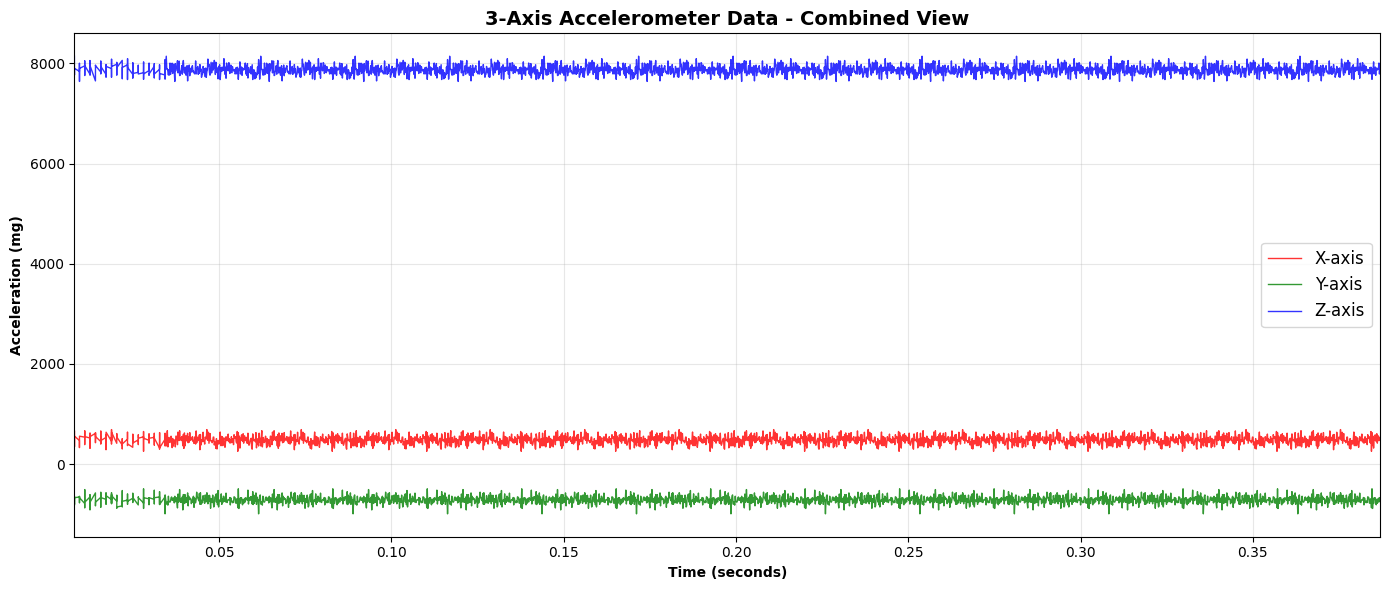

In [338]:
# Create a combined plot showing all axes
def plot_combined_axes(df):
    """
    Create a combined plot showing all three axes on the same graph
    """
    plt.figure(figsize=(14, 6))
    
    plt.plot(df['time_seconds'], df['accel_x'], 'r-', label='X-axis', linewidth=1, alpha=0.8)
    plt.plot(df['time_seconds'], df['accel_y'], 'g-', label='Y-axis', linewidth=1, alpha=0.8)
    plt.plot(df['time_seconds'], df['accel_z'], 'b-', label='Z-axis', linewidth=1, alpha=0.8)
    
    plt.xlabel('Time (seconds)', fontweight='bold')
    plt.ylabel('Acceleration (mg)', fontweight='bold')
    plt.title('3-Axis Accelerometer Data - Combined View', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(df['time_seconds'].min(), df['time_seconds'].max())
    
    plt.tight_layout()
    plt.show()

# Create the combined plot
if 'df' in locals():
    plot_combined_axes(df)
else:
    print("Please run the data loading cell first!")

## 3. Frequency Domain Analysis (FFT)

Now we'll apply Fast Fourier Transform (FFT) to analyze the frequency content of the accelerometer signals. This will help identify any periodic patterns or dominant frequencies in the motion data.

In [339]:
# FFT Analysis
def perform_fft_analysis(df):
    """
    Perform FFT analysis on accelerometer data
    
    Parameters:
    df (pd.DataFrame): DataFrame containing accelerometer data
    
    Returns:
    dict: Dictionary containing frequency arrays, FFT results, and sampling info
    """
    
    # Calculate sampling parameters
    time_diff = np.diff(df['time_seconds'])
    dt = np.mean(time_diff)  # Average sampling interval
    fs = 1 / dt  # Sampling frequency
    N = len(df)  # Number of samples
    
    print(f"Sampling Analysis:")
    print(f"  Average sampling interval: {dt*1000:.2f} ms")
    print(f"  Sampling frequency: {fs:.2f} Hz")
    print(f"  Number of samples: {N}")
    print(f"  Nyquist frequency: {fs/2:.2f} Hz")
    
    # Perform FFT for each axis
    fft_results = {}
    
    for axis in ['accel_x', 'accel_y', 'accel_z']:
        # Remove DC component (mean)
        signal = df[axis] - df[axis].mean()
        
        # Apply window function to reduce spectral leakage
        windowed_signal = signal * np.hanning(len(signal))
        
        # Compute FFT
        fft_values = fft(windowed_signal)
        fft_frequencies = fftfreq(N, dt)
        
        # Take only positive frequencies
        positive_freq_mask = fft_frequencies > 0
        frequencies = fft_frequencies[positive_freq_mask]
        magnitude = np.abs(fft_values[positive_freq_mask])
        
        # Convert to power spectral density
        psd = magnitude ** 2
        
        fft_results[axis] = {
            'frequencies': frequencies,
            'magnitude': magnitude,
            'psd': psd
        }
    
    return fft_results, fs

# Perform FFT analysis
if 'df' in locals():
    fft_results, sampling_freq = perform_fft_analysis(df)
    print("\nFFT analysis completed successfully!")
else:
    print("Please run the data loading cell first!")

Sampling Analysis:
  Average sampling interval: 0.15 ms
  Sampling frequency: 6469.90 Hz
  Number of samples: 2452
  Nyquist frequency: 3234.95 Hz

FFT analysis completed successfully!


In [340]:
# Plot frequency spectrum - Interactive Version
def plot_frequency_spectrum(fft_results, max_freq=None):
    """
    Plot interactive frequency spectrum for all three axes using Plotly
    
    Parameters:
    fft_results (dict): Results from FFT analysis
    max_freq (float): Maximum frequency to display (Hz)
    """
    
    # Create subplots
    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=('X-Axis - Frequency Spectrum', 
                       'Y-Axis - Frequency Spectrum', 
                       'Z-Axis - Frequency Spectrum'),
        vertical_spacing=0.08
    )
    
    colors = ['red', 'green', 'blue']
    axis_names = ['X-Axis', 'Y-Axis', 'Z-Axis']
    axes_data = ['accel_x', 'accel_y', 'accel_z']
    
    peak_annotations = []
    
    for i, (axis, color, name) in enumerate(zip(axes_data, colors, axis_names)):
        frequencies = fft_results[axis]['frequencies']
        magnitude = fft_results[axis]['magnitude']
        
        # Apply frequency limit if specified
        if max_freq is not None:
            freq_mask = frequencies <= max_freq
            frequencies = frequencies[freq_mask]
            magnitude = magnitude[freq_mask]
        
        # Add trace
        fig.add_trace(
            go.Scatter(
                x=frequencies,
                y=magnitude,
                mode='lines',
                line=dict(color=color, width=PLOT_OPTIONS['line_width']),
                name=f'{name}',
                opacity=LINE_ALPHA,
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Frequency: %{x:.2f} Hz<br>' +
                             'Magnitude: %{y:.2f}<br>' +
                             '<extra></extra>',
                yaxis='y' if i == 0 else f'y{i+1}'
            ),
            row=i+1, col=1
        )
        
        # Find and store peak frequencies for annotations
        peak_indices = np.argsort(magnitude)[-5:]  # Top 5 peaks
        for peak_idx in peak_indices:
            if magnitude[peak_idx] > np.max(magnitude) * 0.1:  # Only show significant peaks
                peak_annotations.append({
                    'x': frequencies[peak_idx],
                    'y': magnitude[peak_idx],
                    'text': f'{frequencies[peak_idx]:.1f} Hz',
                    'row': i+1,
                    'showarrow': True,
                    'arrowhead': 2,
                    'arrowsize': 1,
                    'arrowwidth': 1,
                    'arrowcolor': color,
                    'font': dict(size=10, color=color),
                    'bgcolor': 'rgba(255,255,255,0.8)',
                    'bordercolor': color,
                    'borderwidth': 1
                })
    
    # Update y-axes to linear scale
    fig.update_yaxes(title_text="Magnitude", row=1, col=1, gridcolor='lightgray')
    fig.update_yaxes(title_text="Magnitude", row=2, col=1, gridcolor='lightgray')
    fig.update_yaxes(title_text="Magnitude", row=3, col=1, gridcolor='lightgray')
    
    # Update x-axes
    fig.update_xaxes(gridcolor='lightgray', row=1, col=1)
    fig.update_xaxes(gridcolor='lightgray', row=2, col=1)
    fig.update_xaxes(title_text="Frequency (Hz)", gridcolor='lightgray', row=3, col=1)
    
    # Update overall layout
    fig.update_layout(
        title={
            'text': 'Frequency Spectrum Analysis - FFT Results (Interactive)',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'family': 'Arial Black'}
        },
        width=PLOT_OPTIONS['width'],
        height=PLOT_OPTIONS['height'] + 100,  # Slightly taller for 3 subplots
        template=PLOT_OPTIONS['template'],
        showlegend=True,
        font=dict(size=PLOT_OPTIONS['font_size']),
        hovermode='closest'
    )
    
    # Add peak annotations
    annotations = []
    for ann in peak_annotations[:15]:  # Limit to prevent clutter
        annotations.append(dict(
            x=ann['x'],
            y=ann['y'],
            text=ann['text'],
            xref=f"x{ann['row']}" if ann['row'] > 1 else "x",
            yref=f"y{ann['row']}" if ann['row'] > 1 else "y",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor=ann['arrowcolor'],
            font=ann['font'],
            bgcolor=ann['bgcolor'],
            bordercolor=ann['bordercolor'],
            borderwidth=ann['borderwidth'],
            xanchor='center',
            yanchor='bottom'
        ))
    
    fig.update_layout(annotations=annotations)
    
    # Show the plot
    fig.show()

# Plot the frequency spectrum (limit to user-defined max frequency)
if 'fft_results' in locals():
    plot_frequency_spectrum(fft_results, max_freq=USER_MAX_FREQ)
    print("Interactive frequency spectrum plots generated!")
else:
    print("Please run the FFT analysis cell first!")

Interactive frequency spectrum plots generated!


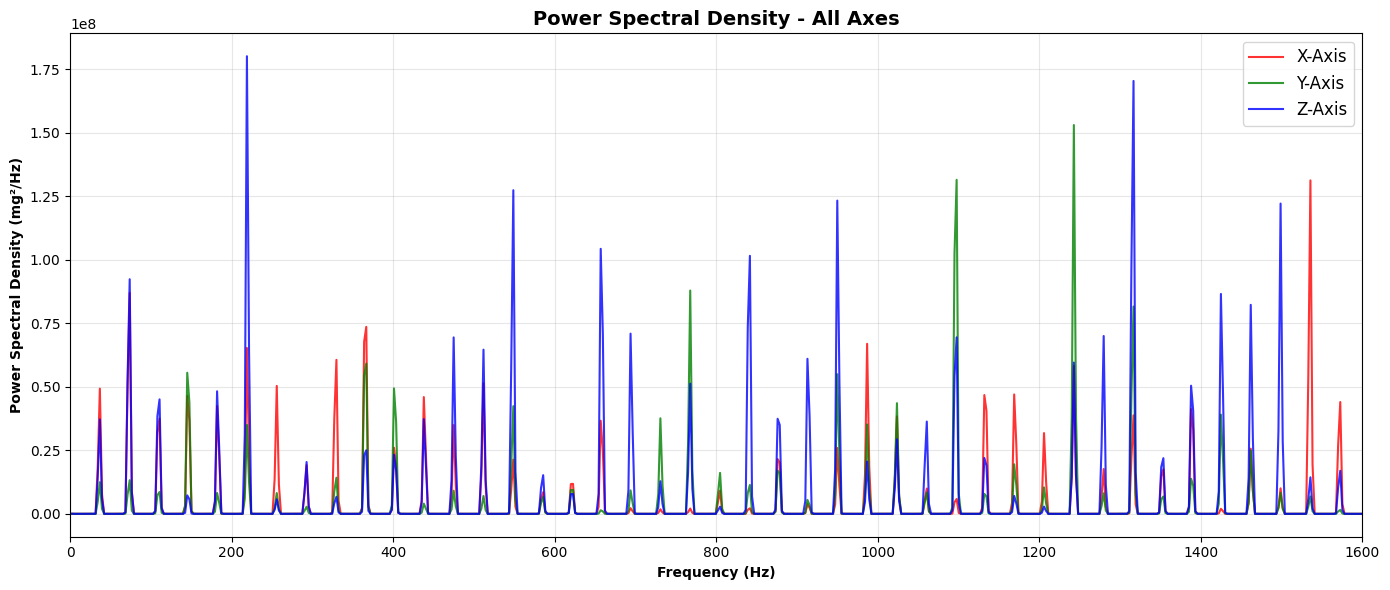

\nDominant Frequency Analysis:
\nACCEL_X - Top 5 Frequencies:
----------------------------------------
  1. 2997.47 Hz - Magnitude:  24847.2
  2. 2630.71 Hz - Magnitude:  16785.1
  3. 2633.34 Hz - Magnitude:  15161.6
  4. 3179.54 Hz - Magnitude:  13624.8
  5. 2192.69 Hz - Magnitude:  13462.6
\nACCEL_Y - Top 5 Frequencies:
----------------------------------------
  1. 2923.59 Hz - Magnitude:  15553.2
  2. 3179.54 Hz - Magnitude:  15049.2
  3. 2084.51 Hz - Magnitude:  14536.7
  4. 2485.58 Hz - Magnitude:  14119.7
  5. 3108.30 Hz - Magnitude:  12869.9
\nACCEL_Z - Top 5 Frequencies:
----------------------------------------
  1. 2997.47 Hz - Magnitude:  15760.9
  2. 3071.36 Hz - Magnitude:  14665.2
  3. 1936.75 Hz - Magnitude:  14015.4
  4. 1899.81 Hz - Magnitude:  13903.3
  5. 2118.81 Hz - Magnitude:  13667.9


In [341]:
# Power Spectral Density Analysis
def plot_power_spectral_density(fft_results, max_freq=None):
    """
    Plot power spectral density for all three axes
    """
    
    plt.figure(figsize=(14, 6))
    
    colors = ['red', 'green', 'blue']
    axis_names = ['X-Axis', 'Y-Axis', 'Z-Axis']
    
    for axis, color, name in zip(['accel_x', 'accel_y', 'accel_z'], colors, axis_names):
        frequencies = fft_results[axis]['frequencies']
        psd = fft_results[axis]['psd']
        
        # Apply frequency limit if specified
        if max_freq is not None:
            freq_mask = frequencies <= max_freq
            frequencies = frequencies[freq_mask]
            psd = psd[freq_mask]
        
        # Plot PSD
        plt.plot(frequencies, psd, color=color, label=name, linewidth=1.5, alpha=0.8)
    
    plt.xlabel('Frequency (Hz)', fontweight='bold')
    plt.ylabel('Power Spectral Density (mg²/Hz)', fontweight='bold')
    plt.title('Power Spectral Density - All Axes', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max_freq if max_freq else frequencies.max())
    
    plt.tight_layout()
    plt.show()

def analyze_dominant_frequencies(fft_results, num_peaks=5):
    """
    Analyze and report dominant frequencies for each axis
    """
    print("\\nDominant Frequency Analysis:")
    print("=" * 60)
    
    for axis in ['accel_x', 'accel_y', 'accel_z']:
        frequencies = fft_results[axis]['frequencies']
        magnitude = fft_results[axis]['magnitude']
        
        # Find peaks
        peak_indices = np.argsort(magnitude)[-num_peaks:][::-1]  # Top peaks, descending
        
        print(f"\\n{axis.upper()} - Top {num_peaks} Frequencies:")
        print("-" * 40)
        for i, peak_idx in enumerate(peak_indices):
            freq = frequencies[peak_idx]
            mag = magnitude[peak_idx]
            print(f"  {i+1}. {freq:6.2f} Hz - Magnitude: {mag:8.1f}")

# Create PSD plot and analyze dominant frequencies
if 'fft_results' in locals():
    plot_power_spectral_density(fft_results, max_freq=USER_MAX_FREQ)
    analyze_dominant_frequencies(fft_results)
else:
    print("Please run the FFT analysis cell first!")

## 4. Advanced Spectral Analysis

Additionally, spectral frequency graphs can be added including spectrograms and enhanced frequency domain visualizations to better understand the time-frequency characteristics of the accelerometer signals.

Sampling frequency: 6469.90 Hz | Data length: 2452 samples | Duration: 0.379s


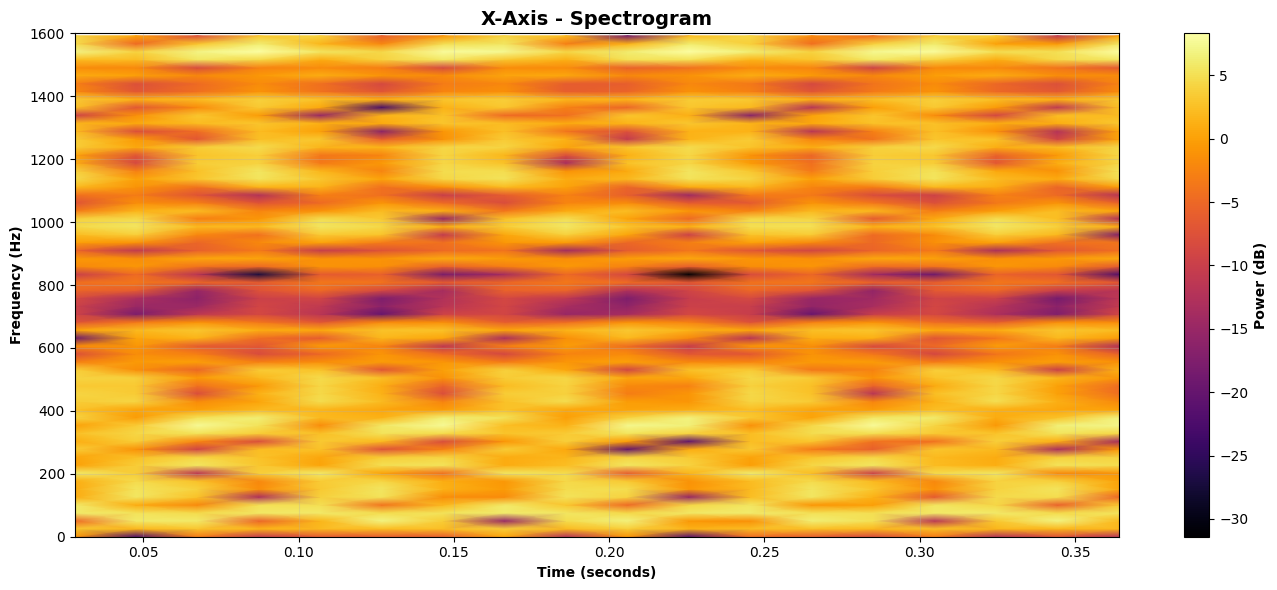

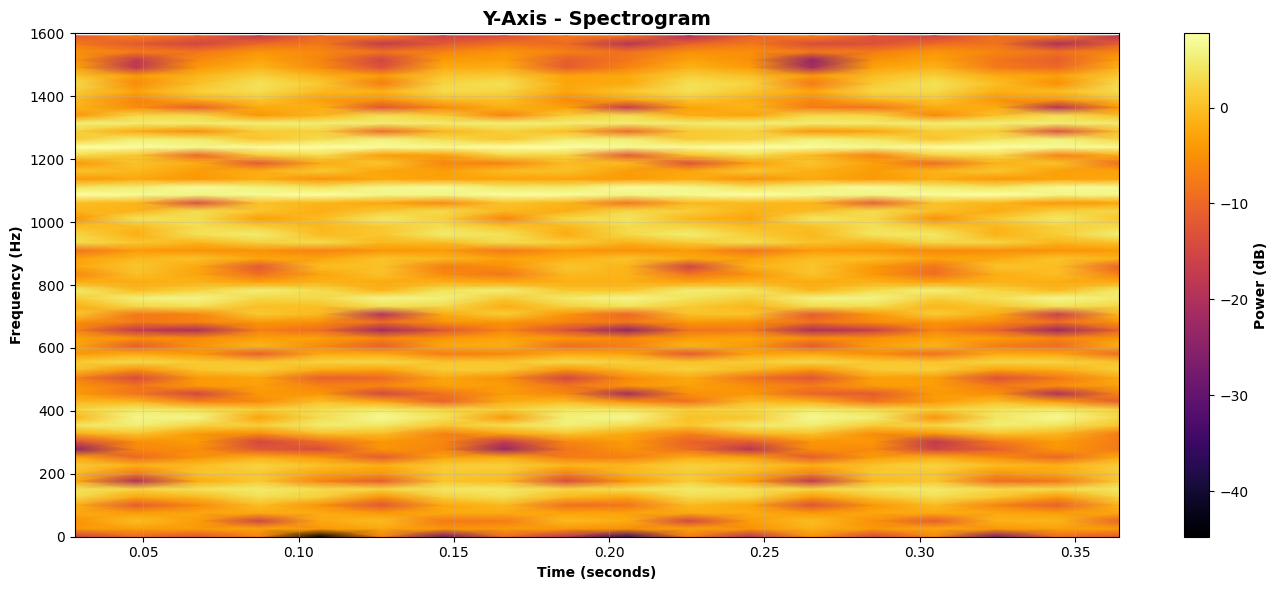

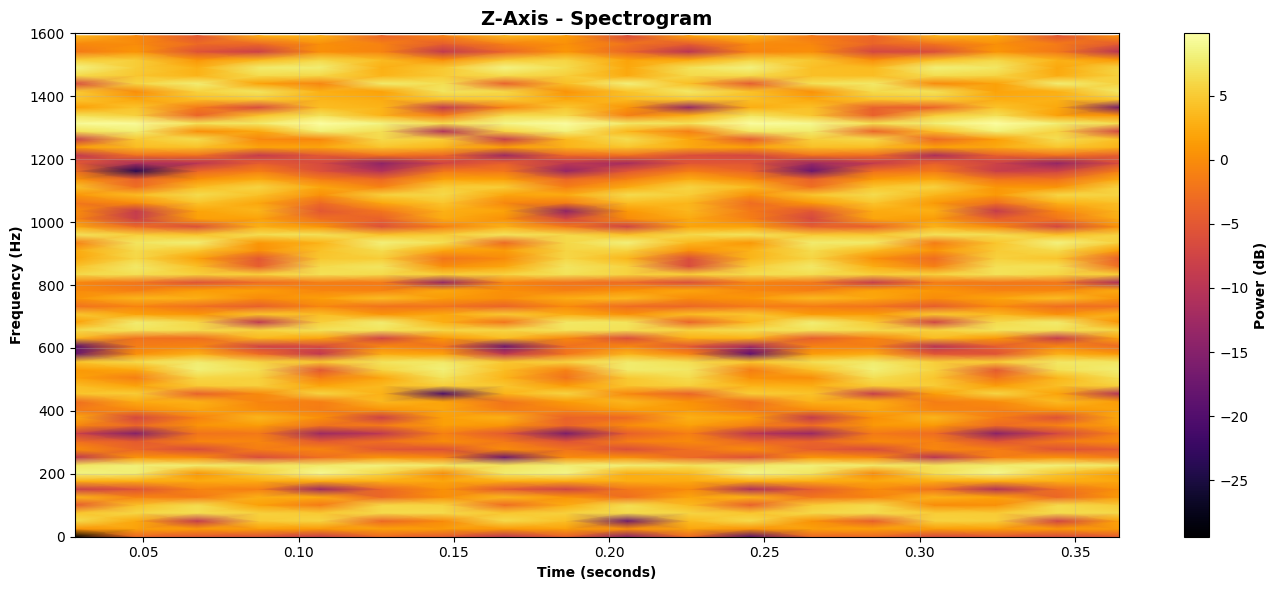

Enhanced interactive spectral frequency analysis completed!


In [342]:
# Enhanced Spectral Frequency Analysis - Interactive Version
from scipy.signal import spectrogram, welch
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_enhanced_spectral_analysis(df, fft_results, max_freq=USER_MAX_FREQ):
    """
    Create comprehensive spectral frequency analysis including:
    - Spectrogram (time-frequency representation) - Matplotlib with high-quality shading
    - Welch's method power spectral density - Interactive Plotly
    """
    
    colors = ['red', 'green', 'blue']
    axis_names = ['X-Axis', 'Y-Axis', 'Z-Axis']
    axes_data = ['accel_x', 'accel_y', 'accel_z']
    
    # Calculate sampling parameters
    time_diff = np.diff(df['time_seconds'])
    dt = np.mean(time_diff)
    fs = 1 / dt
    
    # Print basic sampling information
    print(f"Sampling frequency: {fs:.2f} Hz | Data length: {len(df)} samples | Duration: {df['time_seconds'].max() - df['time_seconds'].min():.3f}s")
    
    # Create separate figures for spectrograms and Welch PSD
    
    # 1. SPECTROGRAMS
    for i, (axis, color, name) in enumerate(zip(axes_data, colors, axis_names)):
        # Remove DC component and convert to numpy array
        signal = (df[axis] - df[axis].mean()).values
        
        # Optimize spectrogram parameters for high-frequency data with short duration
        nperseg = min(256, len(signal)//8)  # Increased segment size for better frequency resolution
        noverlap = nperseg // 2  # 50% overlap
        
        f, t, Sxx = spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap, 
                               window='hann', detrend='constant')
        
        # Limit frequency range
        freq_mask = f <= max_freq
        f_limited = f[freq_mask]
        Sxx_limited = Sxx[freq_mask, :]
        
        # Convert to dB with better scaling
        Sxx_db = 10 * np.log10(Sxx_limited + np.finfo(float).eps)
        
        # Since Plotly doesn't support proper shading like matplotlib's 'gouraud',
        # we'll use matplotlib for better spectrogram visualization
        plt.figure(figsize=(14, 6))
        
        # Create matplotlib spectrogram plot with proper shading
        im = plt.pcolormesh(t + df['time_seconds'].min(), f_limited, Sxx_db, 
                           shading='gouraud', cmap=COLOR_MAP)
        
        plt.ylabel('Frequency (Hz)', fontweight='bold')
        plt.xlabel('Time (seconds)', fontweight='bold')
        plt.title(f'{name} - Spectrogram', fontsize=14, fontweight='bold')
        plt.ylim(0, max_freq)
        plt.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(im)
        cbar.set_label('Power (dB)', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # 2. WELCH PSD PLOTS
    fig_welch = make_subplots(
        rows=3, cols=1,
        subplot_titles=tuple(f'{name} - Welch PSD' for name in axis_names),
        vertical_spacing=0.08
    )
    
    for i, (axis, color, name) in enumerate(zip(axes_data, colors, axis_names)):
        # Remove DC component and convert to numpy array
        signal = (df[axis] - df[axis].mean()).values
        
        # Optimize Welch parameters for high-frequency data
        nperseg_welch = min(512, len(signal)//4)  # Larger segment for better frequency resolution
        
        f_welch, psd_welch = welch(signal, fs, nperseg=nperseg_welch, 
                                  noverlap=nperseg_welch//2, window='hann', 
                                  detrend='constant')
        
        # Limit frequency range
        freq_mask_welch = f_welch <= max_freq
        f_welch_limited = f_welch[freq_mask_welch]
        psd_welch_limited = psd_welch[freq_mask_welch]
        
        # Add trace to subplot
        fig_welch.add_trace(
            go.Scatter(
                x=f_welch_limited,
                y=psd_welch_limited,
                mode='lines',
                line=dict(color=color, width=PLOT_OPTIONS['line_width']),
                name=f'{name}',
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Frequency: %{x:.2f} Hz<br>' +
                             'PSD: %{y:.2e} mg²/Hz<br>' +
                             '<extra></extra>'
            ),
            row=i+1, col=1
        )
    
    # Update Welch PSD layout
    fig_welch.update_yaxes(title_text="PSD (mg²/Hz)", gridcolor='lightgray')
    fig_welch.update_xaxes(gridcolor='lightgray')
    fig_welch.update_xaxes(title_text="Frequency (Hz)", row=3, col=1)
    
    fig_welch.update_layout(
        title={
            'text': 'Welch Power Spectral Density Analysis',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'family': 'Arial Black'}
        },
        width=PLOT_OPTIONS['width'],
        height=PLOT_OPTIONS['height'],
        template=PLOT_OPTIONS['template'],
        showlegend=True,
        font=dict(size=PLOT_OPTIONS['font_size']),
        hovermode='closest'
    )
    
    fig_welch.show()
    
    # 3. COMBINED WELCH PSD COMPARISON
    fig_combined = go.Figure()
    
    for axis, color, name in zip(axes_data, colors, axis_names):
        signal = (df[axis] - df[axis].mean()).values
        nperseg_welch = min(512, len(signal)//4)
        
        f_welch, psd_welch = welch(signal, fs, nperseg=nperseg_welch, 
                                  noverlap=nperseg_welch//2, window='hann', 
                                  detrend='constant')
        
        freq_mask_welch = f_welch <= max_freq
        f_welch_limited = f_welch[freq_mask_welch]
        psd_welch_limited = psd_welch[freq_mask_welch]
        
        fig_combined.add_trace(
            go.Scatter(
                x=f_welch_limited,
                y=psd_welch_limited,
                mode='lines',
                line=dict(color=color, width=PLOT_OPTIONS['line_width']),
                name=name,
                opacity=LINE_ALPHA,
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Frequency: %{x:.2f} Hz<br>' +
                             'PSD: %{y:.2e} mg²/Hz<br>' +
                             '<extra></extra>'
            )
        )
    
    fig_combined.update_layout(
        title={
            'text': 'Combined Welch PSD - All Axes',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'family': 'Arial Black'}
        },
        xaxis_title='Frequency (Hz)',
        yaxis_title='PSD (mg²/Hz)',
        width=PLOT_OPTIONS['width'],
        height=600,
        template=PLOT_OPTIONS['template'],
        font=dict(size=PLOT_OPTIONS['font_size']),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        hovermode='x unified'
    )
    
    fig_combined.update_xaxes(gridcolor='lightgray', zeroline=True)
    fig_combined.update_yaxes(gridcolor='lightgray', zeroline=True)
    
    fig_combined.show()

# Create enhanced spectral analysis
if 'df' in locals() and 'fft_results' in locals():
    plot_enhanced_spectral_analysis(df, fft_results, max_freq=USER_MAX_FREQ)
    print("Enhanced interactive spectral frequency analysis completed!")
else:
    print("Please run the data loading and FFT analysis cells first!")

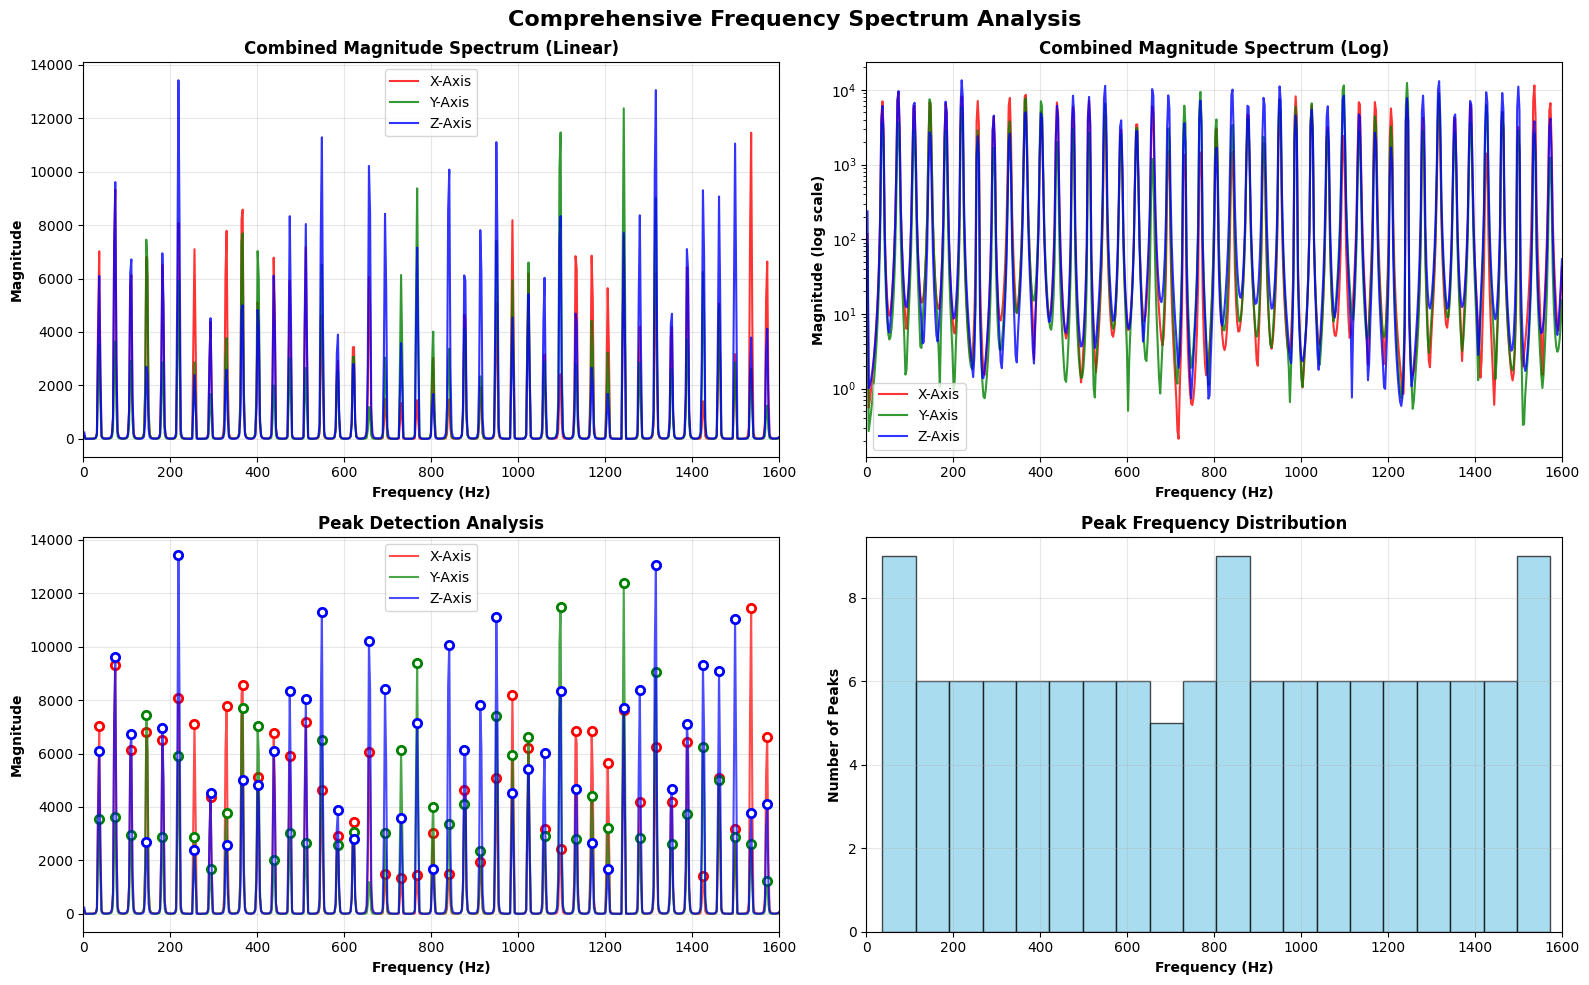

\nPeak Detection Results:
\nX-Axis:
--------------------
  Peak 1: 1535.68 Hz (Magnitude:  11456.6)
  Peak 2:  73.88 Hz (Magnitude:   9326.2)
  Peak 3: 366.77 Hz (Magnitude:   8579.1)
  Peak 4: 986.84 Hz (Magnitude:   8181.0)
  Peak 5: 219.01 Hz (Magnitude:   8080.3)
\nY-Axis:
--------------------
  Peak 1: 1242.79 Hz (Magnitude:  12370.7)
  Peak 2: 1097.67 Hz (Magnitude:  11466.0)
  Peak 3: 767.84 Hz (Magnitude:   9375.2)
  Peak 4: 1316.67 Hz (Magnitude:   9033.2)
  Peak 5: 366.77 Hz (Magnitude:   7689.1)
\nZ-Axis:
--------------------
  Peak 1: 219.01 Hz (Magnitude:  13421.0)
  Peak 2: 1316.67 Hz (Magnitude:  13053.4)
  Peak 3: 548.83 Hz (Magnitude:  11286.1)
  Peak 4: 949.90 Hz (Magnitude:  11103.9)
  Peak 5: 1498.74 Hz (Magnitude:  11051.2)


In [343]:
# Comprehensive Frequency Spectrum with Peak Detection
from scipy.signal import find_peaks

def plot_comprehensive_frequency_spectrum(fft_results, sampling_freq, max_freq=USER_MAX_FREQ):
    """
    Create a comprehensive frequency spectrum analysis with peak detection
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Comprehensive Frequency Spectrum Analysis', fontsize=16, fontweight='bold')
    
    colors = ['red', 'green', 'blue']
    axis_names = ['X-Axis', 'Y-Axis', 'Z-Axis']
    axes_data = ['accel_x', 'accel_y', 'accel_z']
    
    # Plot 1: Combined Magnitude Spectrum (Linear Scale)
    ax1 = axes[0, 0]
    for axis, color, name in zip(axes_data, colors, axis_names):
        frequencies = fft_results[axis]['frequencies']
        magnitude = fft_results[axis]['magnitude']
        
        # Apply frequency limit
        freq_mask = frequencies <= max_freq
        frequencies_limited = frequencies[freq_mask]
        magnitude_limited = magnitude[freq_mask]
        
        ax1.plot(frequencies_limited, magnitude_limited, color=color, label=name, linewidth=1.5, alpha=0.8)
    
    ax1.set_xlabel('Frequency (Hz)', fontweight='bold')
    ax1.set_ylabel('Magnitude', fontweight='bold')
    ax1.set_title('Combined Magnitude Spectrum (Linear)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max_freq)
    
    # Plot 2: Combined Magnitude Spectrum (Log Scale)
    ax2 = axes[0, 1]
    for axis, color, name in zip(axes_data, colors, axis_names):
        frequencies = fft_results[axis]['frequencies']
        magnitude = fft_results[axis]['magnitude']
        
        freq_mask = frequencies <= max_freq
        frequencies_limited = frequencies[freq_mask]
        magnitude_limited = magnitude[freq_mask]
        
        ax2.semilogy(frequencies_limited, magnitude_limited, color=color, label=name, linewidth=1.5, alpha=0.8)
    
    ax2.set_xlabel('Frequency (Hz)', fontweight='bold')
    ax2.set_ylabel('Magnitude (log scale)', fontweight='bold')
    ax2.set_title('Combined Magnitude Spectrum (Log)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, max_freq)
    
    # Plot 3: Peak Detection Analysis
    ax3 = axes[1, 0]
    peak_data = {}
    
    for axis, color, name in zip(axes_data, colors, axis_names):
        frequencies = fft_results[axis]['frequencies']
        magnitude = fft_results[axis]['magnitude']
        
        freq_mask = frequencies <= max_freq
        frequencies_limited = frequencies[freq_mask]
        magnitude_limited = magnitude[freq_mask]
        
        # Find peaks
        peaks, properties = find_peaks(magnitude_limited, 
                                     height=np.max(magnitude_limited) * 0.1,
                                     distance=5)
        
        ax3.plot(frequencies_limited, magnitude_limited, color=color, label=name, alpha=0.7)
        ax3.plot(frequencies_limited[peaks], magnitude_limited[peaks], 
                'o', color=color, markersize=6, markerfacecolor='white', 
                markeredgewidth=2, markeredgecolor=color)
        
        # Store peak information
        peak_data[axis] = {
            'frequencies': frequencies_limited[peaks],
            'magnitudes': magnitude_limited[peaks]
        }
    
    ax3.set_xlabel('Frequency (Hz)', fontweight='bold')
    ax3.set_ylabel('Magnitude', fontweight='bold')
    ax3.set_title('Peak Detection Analysis', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, max_freq)
    
    # Plot 4: Frequency Distribution Histogram
    ax4 = axes[1, 1]
    all_peaks = []
    peak_colors = []
    peak_labels = []
    
    for axis, color, name in zip(axes_data, colors, axis_names):
        if len(peak_data[axis]['frequencies']) > 0:
            all_peaks.extend(peak_data[axis]['frequencies'])
            peak_colors.extend([color] * len(peak_data[axis]['frequencies']))
            peak_labels.extend([name] * len(peak_data[axis]['frequencies']))
    
    if all_peaks:
        ax4.hist(all_peaks, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax4.set_xlabel('Frequency (Hz)', fontweight='bold')
        ax4.set_ylabel('Number of Peaks', fontweight='bold')
        ax4.set_title('Peak Frequency Distribution', fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim(0, max_freq)
    
    plt.tight_layout()
    plt.show()
    
    # Print peak analysis
    print("\\nPeak Detection Results:")
    print("=" * 60)
    for axis, name in zip(axes_data, axis_names):
        peaks_freq = peak_data[axis]['frequencies']
        peaks_mag = peak_data[axis]['magnitudes']
        
        print(f"\\n{name}:")
        print("-" * 20)
        if len(peaks_freq) > 0:
            # Sort by magnitude (descending)
            sorted_indices = np.argsort(peaks_mag)[::-1]
            for i, idx in enumerate(sorted_indices[:5]):  # Top 5 peaks
                print(f"  Peak {i+1}: {peaks_freq[idx]:6.2f} Hz (Magnitude: {peaks_mag[idx]:8.1f})")
        else:
            print("  No significant peaks detected")

# Create comprehensive frequency spectrum analysis
if 'fft_results' in locals() and 'sampling_freq' in locals():
    plot_comprehensive_frequency_spectrum(fft_results, sampling_freq, max_freq=USER_MAX_FREQ)
else:
    print("Please run the FFT analysis cell first!")

## 5. Analysis Summary

This analysis provides insights into the accelerometer data collected from the IIS3DWB sensor:

### Key Findings:
1. **Time Domain**: The time series plots show the acceleration patterns across all three axes
2. **Frequency Domain**: FFT analysis reveals the frequency content and dominant frequencies in the signal
3. **Advanced Spectral Analysis**: Spectrograms show time-frequency evolution of the signals
4. **Welch PSD**: Power spectral density analysis using Welch's method for improved frequency resolution
5. **Peak Detection**: Automated detection and analysis of dominant frequency components
6. **Motion Characteristics**: The comprehensive frequency spectrum helps identify periodic motion patterns and vibrations